In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify index_col=0 to avoid creating an "Unnamed: 0" column.
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data.csv') 
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,5/21/2014,360000.0,3,2.50,1530,1131,3.0,NO,NONE,...,8 Good,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2/23/2015,400000.0,4,2.50,2310,5813,2.0,NO,NONE,...,8 Good,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,6/23/2014,402101.0,2,0.75,1020,1350,2.0,NO,NONE,...,7 Average,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,NONE,...,8 Good,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
len(df)

21597

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# Fill NaNs and Drop Duplicates

### Duplicates

In [5]:
df.duplicated().sum()

0

### NaNs

In [6]:
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [7]:
waterfront_count = print(df['waterfront'].value_counts())

NO     19075
YES      146
Name: waterfront, dtype: int64


In [8]:
df['waterfront'].fillna('NO', inplace=True)

In [9]:
yr_renovated_count = print(df['yr_renovated'].value_counts())

0.0       17011
2014.0       73
2013.0       31
2003.0       31
2007.0       30
          ...  
1951.0        1
1953.0        1
1946.0        1
1976.0        1
1948.0        1
Name: yr_renovated, Length: 70, dtype: int64


In [10]:
df['yr_renovated'].fillna(2022, inplace=True)

In [11]:
df.drop(['date', 'id'], axis=1, inplace=True)

# Train-Test Split

In [12]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [13]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [14]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [15]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Price

In [17]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q75, price_q25 = np.percentile(df['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -162500.0 
price_max: 1129500.0


In [18]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [19]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -2974.75 
sqft_lot_max: 18291.25


In [20]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Grade

In [21]:
grade_count = print(df['grade'].value_counts())

7 Average        8372
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64


In [22]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

# Categorical Variables

### Bedroom

In [23]:
bed_count = df['bedrooms'].value_counts()
bed_count

3     8610
4     5480
2     2547
5     1167
6      197
1      171
7       24
8        9
9        4
10       2
11       1
33       1
Name: bedrooms, dtype: int64

In [24]:
#drop the 33 bedroom outlier 
df = df[df['bedrooms'] != 33]
df = df[df['bedrooms'] != 11]
df = df[df['bedrooms'] != 10]
#df = df[df['bedrooms'] != 9]
#df = df[df['bedrooms'] != 8]
#df = df[df['bedrooms'] != 7]

### Condition

In [25]:
condition_count = df['condition'].value_counts()
condition_count

Average      11899
Good          4724
Very Good     1433
Fair           132
Poor            21
Name: condition, dtype: int64

In [26]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [27]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [28]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Grade

In [29]:
grade_count = print(df['grade'].value_counts())

7 Average        8368
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
Name: grade, dtype: int64


In [30]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

### Floors

In [31]:
floor_count = print(df['floors'].value_counts())

1.0    9371
2.0    6561
1.5    1607
3.0     568
2.5      96
3.5       6
Name: floors, dtype: int64


In [32]:
X_train, X_test, encoded_floors = ohe(X_train, X_test, ['floors'])

In [33]:
#X_train['floors'] = X_train['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

In [34]:
#X_test['floors'] = X_test['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

### View

In [35]:
X_train['view'].isna().sum()

49

In [36]:
view_count = df['view'].value_counts()
view_count

NONE         16867
AVERAGE        681
GOOD           257
FAIR           246
EXCELLENT      104
Name: view, dtype: int64

In [37]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [38]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [39]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [40]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [41]:
waterfront_count = print(df['waterfront'].value_counts())

NO     18183
YES       26
Name: waterfront, dtype: int64


In [42]:
X_train, X_test, encoded_waterfront = ohe(X_train, X_test, ['waterfront'])

In [43]:
X_train['waterfront'] = X_train['waterfront'].map({'NO': 0, 'YES': 1})

In [44]:
X_test['waterfront'] = X_test['waterfront'].map({'NO': 0, 'YES': 1})

### Zipcode

In [45]:
zipcode_count = print(df['zipcode'].sort_values().value_counts())

98103    587
98115    557
98117    543
98052    514
98034    507
        ... 
98010     46
98077     43
98070     28
98024     26
98039      6
Name: zipcode, Length: 70, dtype: int64


In [46]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Mutlitcollinearity

In [47]:
df.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.293376,0.429236,0.598962,-0.005254,0.262921,0.492521,0.024583,0.032775,0.003292,0.450087,0.034715,0.536539,-0.024647
bedrooms,0.293376,1.000000,0.505521,0.625350,0.205053,0.155691,0.497011,0.170964,-0.010390,-0.160393,-0.047577,0.157255,0.396516,0.124377
bathrooms,0.429236,0.505521,1.000000,0.711655,-0.012229,0.513446,0.633781,0.549604,-0.005463,-0.210199,-0.019529,0.252654,0.531032,-0.021561
sqft_living,0.598962,0.625350,0.711655,1.000000,0.225665,0.338671,0.843739,0.347117,-0.001626,-0.194371,0.006652,0.266066,0.739471,0.144716
sqft_lot,-0.005254,0.205053,-0.012229,0.225665,1.000000,-0.349162,0.178481,-0.040399,-0.004911,-0.253186,-0.141457,0.252918,0.264772,0.694641
floors,0.262921,0.155691,0.513446,0.338671,-0.349162,1.000000,0.535690,0.521324,-0.007718,-0.068669,0.022829,0.143026,0.270393,-0.263480
sqft_above,0.492521,0.497011,0.633781,0.843739,0.178481,0.535690,1.000000,0.466979,-0.011552,-0.273127,-0.062805,0.388315,0.719017,0.119120
yr_built,0.024583,0.170964,0.549604,0.347117,-0.040399,0.521324,0.466979,1.000000,-0.089923,-0.348628,-0.177098,0.423915,0.362884,-0.021901
yr_renovated,0.032775,-0.010390,-0.005463,-0.001626,-0.004911,-0.007718,-0.011552,-0.089923,1.000000,0.040364,0.025300,-0.035816,-0.025329,-0.000726
zipcode,0.003292,-0.160393,-0.210199,-0.194371,-0.253186,-0.068669,-0.273127,-0.348628,0.040364,1.000000,0.284086,-0.571154,-0.281040,-0.194702


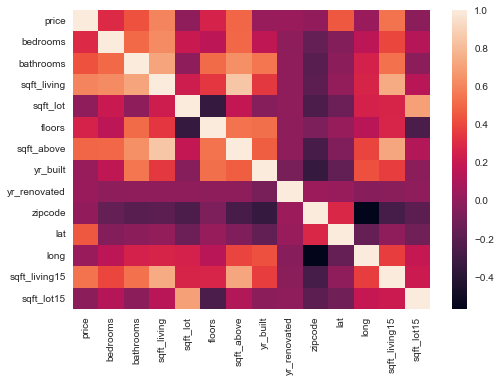

In [48]:
sns.heatmap(df.corr());

In [49]:
df.corr()['price'].abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.598962
sqft_living15    0.536539
sqft_above       0.492521
lat              0.450087
bathrooms        0.429236
bedrooms         0.293376
floors           0.262921
long             0.034715
yr_renovated     0.032775
sqft_lot15       0.024647
yr_built         0.024583
sqft_lot         0.005254
zipcode          0.003292
Name: price, dtype: float64

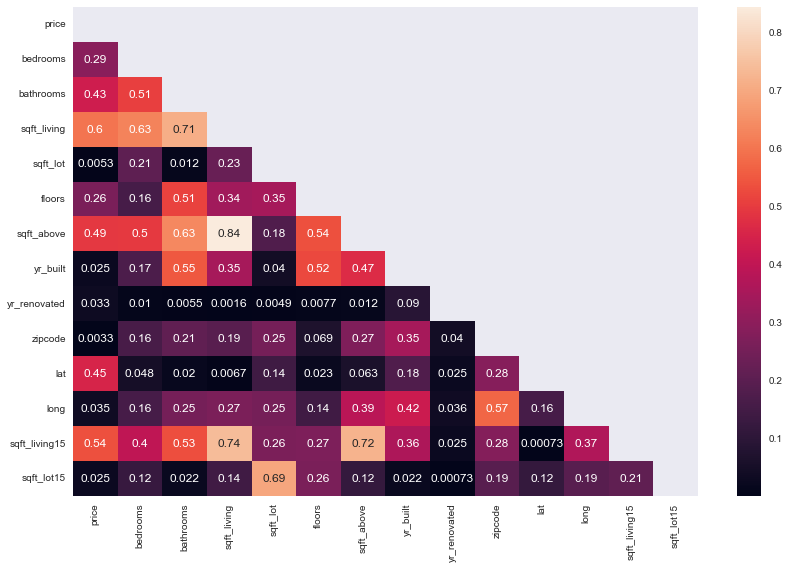

In [50]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_22',bbox_inches="tight");

In [ ]:
#df.drop(['sqft_above'], axis=1, inplace=True)

# Models

In [51]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -0.0001137788699303588


### Model 1

In [52]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [53]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.49055555791820304
    test score: 0.4988509662233589


In [54]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.491
Mean Absolute Error: 174170.693
Mean Squared Error: 68367540826.669
Root Mean Squared Error: 261471.874

Testing Metrics:
R2: 0.499
Mean Absolute Error: 171964.828
Mean Squared Error: 68757502351.261
Root Mean Squared Error: 262216.518


### Model 2

In [55]:
cols = encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [56]:
X_train_scaled, X_test_scaled, train_preds, test_preds=scale_score(x, y, x2, y2)

training score: 0.4129738083010839
    test score: 0.3875914582022817


In [57]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.413
Mean Absolute Error: 162416.107
Mean Squared Error: 78779026351.328
Root Mean Squared Error: 280676.017

Testing Metrics:
R2: 0.388
Mean Absolute Error: 160980.373
Mean Squared Error: 84022274642.070
Root Mean Squared Error: 289865.960


### Model 3

In [58]:
cols = encoded_grade

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [59]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.5257896973506078
    test score: 0.5021755258904408


In [60]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.526
Mean Absolute Error: 164123.384
Mean Squared Error: 63639112626.935
Root Mean Squared Error: 252267.938

Testing Metrics:
R2: 0.502
Mean Absolute Error: 164516.255
Mean Squared Error: 68301373727.399
Root Mean Squared Error: 261345.315


### Model 4

In [61]:
cols = encoded_view

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [62]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.16993781408329567
    test score: 0.14904237855748437


In [63]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.170
Mean Absolute Error: 217827.947
Mean Squared Error: 111394502906.801
Root Mean Squared Error: 333758.150

Testing Metrics:
R2: 0.149
Mean Absolute Error: 219852.707
Mean Squared Error: 116751139309.259
Root Mean Squared Error: 341688.658


### Model 5

In [64]:
cols = encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [65]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.07164446935760316
    test score: 0.06451160701491343


In [66]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.072
Mean Absolute Error: 229750.166
Mean Squared Error: 124585488426.366
Root Mean Squared Error: 352966.696

Testing Metrics:
R2: 0.065
Mean Absolute Error: 230585.907
Mean Squared Error: 128348736693.200
Root Mean Squared Error: 358257.919


### Model 6

In [67]:
cols = encoded_grade + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [68]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7167492714788091
    test score: 0.6939355566319894


In [69]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.717
Mean Absolute Error: 113887.864
Mean Squared Error: 38012301532.278
Root Mean Squared Error: 194967.437

Testing Metrics:
R2: 0.694
Mean Absolute Error: 114126.614
Mean Squared Error: 41991953024.283
Root Mean Squared Error: 204919.382


### Model 7

In [70]:
cols = encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [71]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.765188133333665
    test score: 0.7318115069589561


In [72]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.765
Mean Absolute Error: 106543.245
Mean Squared Error: 31511797077.020
Root Mean Squared Error: 177515.625

Testing Metrics:
R2: 0.732
Mean Absolute Error: 107474.674
Mean Squared Error: 36795383604.529
Root Mean Squared Error: 191821.228


### Model 8

In [73]:
cols = ['sqft_living'] + encoded_grade + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [74]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7862356079038308
    test score: 0.7702206254493553


In [75]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.786
Mean Absolute Error: 98254.391
Mean Squared Error: 28687221994.614
Root Mean Squared Error: 169373.026

Testing Metrics:
R2: 0.770
Mean Absolute Error: 98452.169
Mean Squared Error: 31525663667.105
Root Mean Squared Error: 177554.678


### Model 9

In [76]:
cols = ['sqft_living'] + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [77]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8207143015518684
    test score: 0.7971522674623294


In [78]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.821
Mean Absolute Error: 91674.775
Mean Squared Error: 24060174762.536
Root Mean Squared Error: 155113.425

Testing Metrics:
R2: 0.797
Mean Absolute Error: 92639.238
Mean Squared Error: 27830650179.649
Root Mean Squared Error: 166825.208


### Model 10

In [79]:
cols = ['sqft_living'] + encoded_grade + encoded_view + encoded_waterfront + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [80]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.832541178089801
    test score: 0.8091229226666838


In [81]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.833
Mean Absolute Error: 90494.100
Mean Squared Error: 22473005686.248
Root Mean Squared Error: 149909.992

Testing Metrics:
R2: 0.809
Mean Absolute Error: 92269.729
Mean Squared Error: 26188279751.122
Root Mean Squared Error: 161827.933


### Model 11

In [82]:
cols = ['bathrooms', 'bedrooms', 'floors', 'sqft_living', 'yr_built'] + encoded_zipcode + encoded_grade + encoded_view + encoded_waterfront

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [83]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.8354262909667811
    test score: 0.811984254155029


In [84]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.835
Mean Absolute Error: 89400.987
Mean Squared Error: 22085822990.524
Root Mean Squared Error: 148612.997

Testing Metrics:
R2: 0.812
Mean Absolute Error: 91346.751
Mean Squared Error: 25795705899.278
Root Mean Squared Error: 160610.417
